<a href="https://colab.research.google.com/github/Sumalyo/MONN_work/blob/main/MONN_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

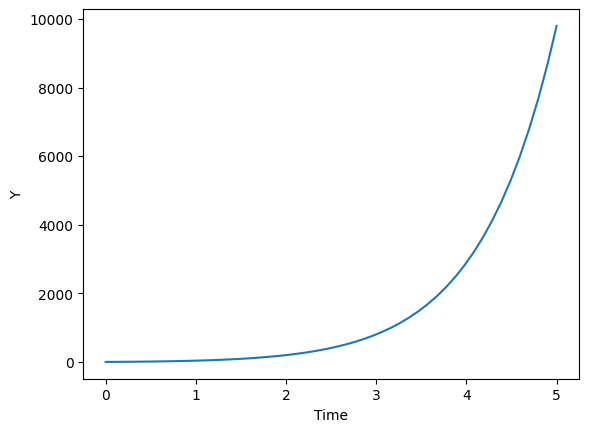

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial condition
y0 = 1

# Time points
t = np.linspace(0, 5)

# Define the differential equation using lambda
# dy/dt = -y * t + 13
dydt = lambda y, t: 13 * np.exp(t) + y

# Solve the ODE
y = odeint(dydt, y0, t)

plt.plot(t, y)
plt.xlabel("Time")
plt.ylabel("Y")
plt.show()

Starting simulation for 0.5 seconds...
Simulation finished. Plotting results.


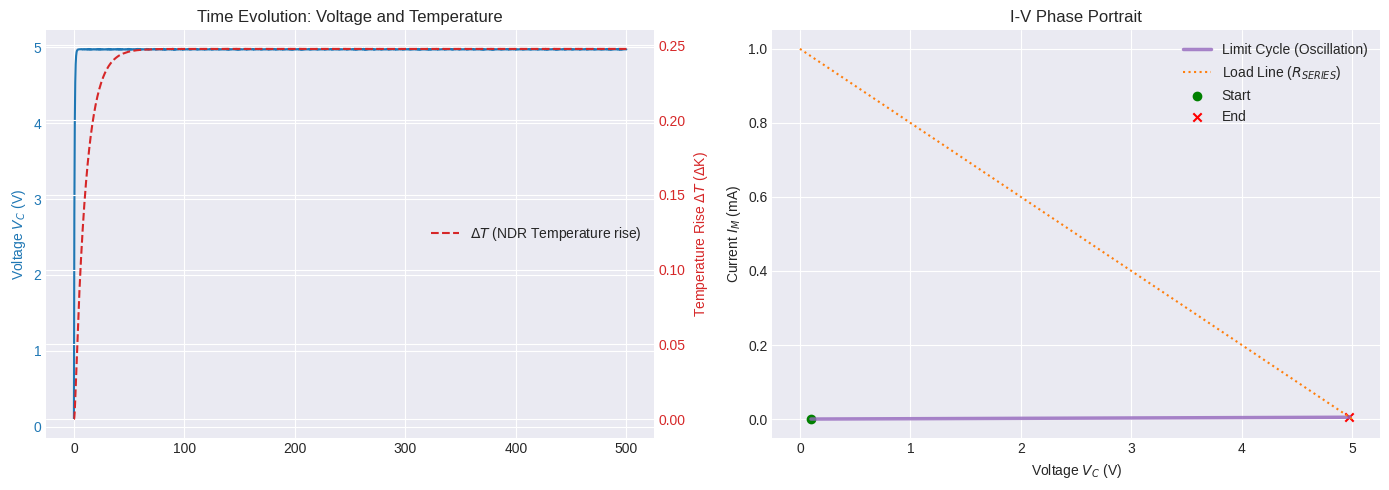


--- Simulation Summary ---
Final V_C range: 0.100 V to 4.981 V
Final T range: 300.0 K to 300.2 K (Delta T: 0.2 K)
NDR device must have an S-type characteristic for these parameters to oscillate.


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Circuit and Model Parameters ---

# Circuit parameters (External components)
V_BIAS = 5.0    # DC Supply Voltage (Volts)
R_SERIES = 5e3  # Series Load Resistor (Ohms). Must be large enough to enable NDR operation.
C_CAP = 100e-9  # External Capacitor (Farads). Provides the slow voltage dynamics.

# Thermal NDR Model Parameters (Device parameters)
T_AMB = 300.0   # Ambient Temperature (Kelvin)
C_TH = 1e-6     # Thermal Capacitance (J/K)
G_TH = 1e-4     # Thermal Conductance to ambient (W/K) (1/R_th)

# Electrical Conductance Parameters
# This model uses an Arrhenius-like temperature dependence for conductance,
# which is common for oxide-based threshold switches.
G_0 = 1e-6      # Low-temp (leakage) conductance (Siemens)
G_1 = 0.5e-3    # Factor for high-temp conductance (Siemens)
E_A = 0.4       # Activation Energy (eV) - determines sensitivity to temp
K_B = 8.617e-5  # Boltzmann Constant (eV/K)

# --- 2. Defining the System of ODEs (The Derivatives) ---

def electro_thermal_ndr_ode(t, Y):
    """
    Defines the system of two coupled ordinary differential equations (ODEs).

    The state vector Y = [V_C, T], where:
    V_C: Voltage across the capacitor (and NDR device)
    T: Temperature of the active region of the NDR device

    dY/dt = [dV_C/dt, dT/dt]

    Args:
        t (float): Time (s)
        Y (np.array): State vector [V_C, T] at time t

    Returns:
        np.array: The time derivative vector [dV_C/dt, dT_dt]
    """
    V_C, T = Y

    # --- Step 1: Calculate the NDR device's dynamic conductance G(T) ---
    # G(T) = G_0 + G_1 * exp(-E_A / (K_B * T))
    # Note: The exponential term causes the conductance to increase rapidly
    # when T increases, which is the source of the thermal positive feedback.
    try:
        G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
    except OverflowError:
        # Handle potential overflow if T gets extremely low (shouldn't happen here)
        G_M = G_0

    # --- Step 2: Calculate Current and Power ---
    I_M = G_M * V_C  # Current through the NDR device
    P_M = I_M * V_C  # Power dissipated by Joule heating

    # --- Step 3: Calculate the Derivatives ---

    # 1. dV_C/dt (Electrical Circuit Equation - KCL)
    # C * dV_C/dt = (V_BIAS - V_C) / R_SERIES - I_M
    I_R = (V_BIAS - V_C) / R_SERIES
    dV_C_dt = (I_R - I_M) / C_CAP

    # 2. dT/dt (Thermal Equation - Energy Balance)
    # C_th * dT/dt = P_M - G_TH * (T - T_AMB)
    P_diss = G_TH * (T - T_AMB)
    dT_dt = (P_M - P_diss) / C_TH

    return np.array([dV_C_dt, dT_dt])

# --- 3. Simulation Setup and Execution ---

# Initial conditions (V_C and T)
# Start near a stable point, but slightly perturbed, or low voltage.
Y0 = np.array([0.1, T_AMB])

# Time span for the simulation
T_SPAN = [0, 0.5] # 0 to 0.5 seconds
T_POINTS = np.linspace(T_SPAN[0], T_SPAN[1], 5000)

print(f"Starting simulation for {T_SPAN[1]} seconds...")

# Solve the ODE system
solution = solve_ivp(
    electro_thermal_ndr_ode,
    T_SPAN,
    Y0,
    t_eval=T_POINTS,
    method='RK45', # Runge-Kutta method for accuracy
    atol=1e-6,
    rtol=1e-3
)
# solution = odeint(
#     electro_thermal_ndr_ode,
#     T_SPAN,
#     Y0,
#     t_eval=T_POINTS,
#     method='RK45', # Runge-Kutta method for accuracy
#     atol=1e-6,
#     rtol=1e-3
# )

print("Simulation finished. Plotting results.")

# Extract results
V_C_sim = solution.y[0]
T_sim = solution.y[1]
t_sim = solution.t

# Calculate I_M and NDR I-V characteristic (for plotting the characteristic curve)
I_M_sim = np.zeros_like(V_C_sim)
for i in range(len(V_C_sim)):
    T = T_sim[i]
    G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
    I_M_sim[i] = G_M * V_C_sim[i]

# --- 4. Plotting Results ---

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 5))

# --- Plot 1: Voltage and Temperature vs. Time ---
plt.subplot(1, 2, 1)
plt.plot(t_sim * 1000, V_C_sim, label='$V_C$ (Voltage across NDR)', color='tab:blue')
plt.ylabel('Voltage $V_C$ (V)', color='tab:blue')
plt.tick_params(axis='y', labelcolor='tab:blue')

# Create a second axis for temperature
ax2 = plt.gca().twinx()
# FIX: Use raw string (r'...') to prevent Python from interpreting \D as an escape sequence
ax2.plot(t_sim * 1000, T_sim - T_AMB, label=r'$\Delta T$ (NDR Temperature rise)', color='tab:red', linestyle='--')
# FIX: Use raw string (r'...') to prevent Python from interpreting \D as an escape sequence
ax2.set_ylabel(r'Temperature Rise $\Delta T$ ($\Delta$K)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Time Evolution: Voltage and Temperature')
plt.xlabel('Time (ms)')
plt.legend(loc='center right')


# --- Plot 2: NDR I-V Characteristic (Phase Portrait) ---
plt.subplot(1, 2, 2)
# Calculate the load line (I_R vs. V_C at the equilibrium points)
# I_R = (V_BIAS - V_C) / R_SERIES
V_C_load = np.linspace(0, V_BIAS, 100)
I_R_load = (V_BIAS - V_C_load) / R_SERIES

plt.plot(V_C_sim, I_M_sim * 1000, label='Limit Cycle (Oscillation)', color='tab:purple', linewidth=2.5, alpha=0.8)
plt.plot(V_C_load, I_R_load * 1000, label=r'Load Line ($R_{SERIES}$)', color='tab:orange', linestyle=':')
plt.scatter(V_C_sim[0], I_M_sim[0] * 1000, color='green', marker='o', label='Start')
plt.scatter(V_C_sim[-1], I_M_sim[-1] * 1000, color='red', marker='x', label='End')

plt.title('I-V Phase Portrait')
plt.xlabel('Voltage $V_C$ (V)')
plt.ylabel('Current $I_M$ (mA)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Print Final Oscillation Info ---
print("\n--- Simulation Summary ---")
print(f"Final V_C range: {np.min(V_C_sim):.3f} V to {np.max(V_C_sim):.3f} V")
print(f"Final T range: {np.min(T_sim):.1f} K to {np.max(T_sim):.1f} K (Delta T: {np.max(T_sim) - T_AMB:.1f} K)")
print(f"NDR device must have an S-type characteristic for these parameters to oscillate.")

<>:141: SyntaxWarning: invalid escape sequence '\D'
<>:156: SyntaxWarning: invalid escape sequence '\_'
<>:141: SyntaxWarning: invalid escape sequence '\D'
<>:156: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipython-input-501764062.py:141: SyntaxWarning: invalid escape sequence '\D'
  plt.title('Time Evolution: $V_C$ and $\Delta T$ (Solver Comparison)')
/tmp/ipython-input-501764062.py:156: SyntaxWarning: invalid escape sequence '\_'
  plt.plot(V_C_ivp, I_M_ivp * 1000, label='Limit Cycle (solve\_ivp)', color='tab:purple', linewidth=2.5, alpha=0.8)


Starting simulation for 0.5 seconds...
solve_ivp simulation finished.

Starting simulation using odeint...
odeint simulation finished. Plotting results.


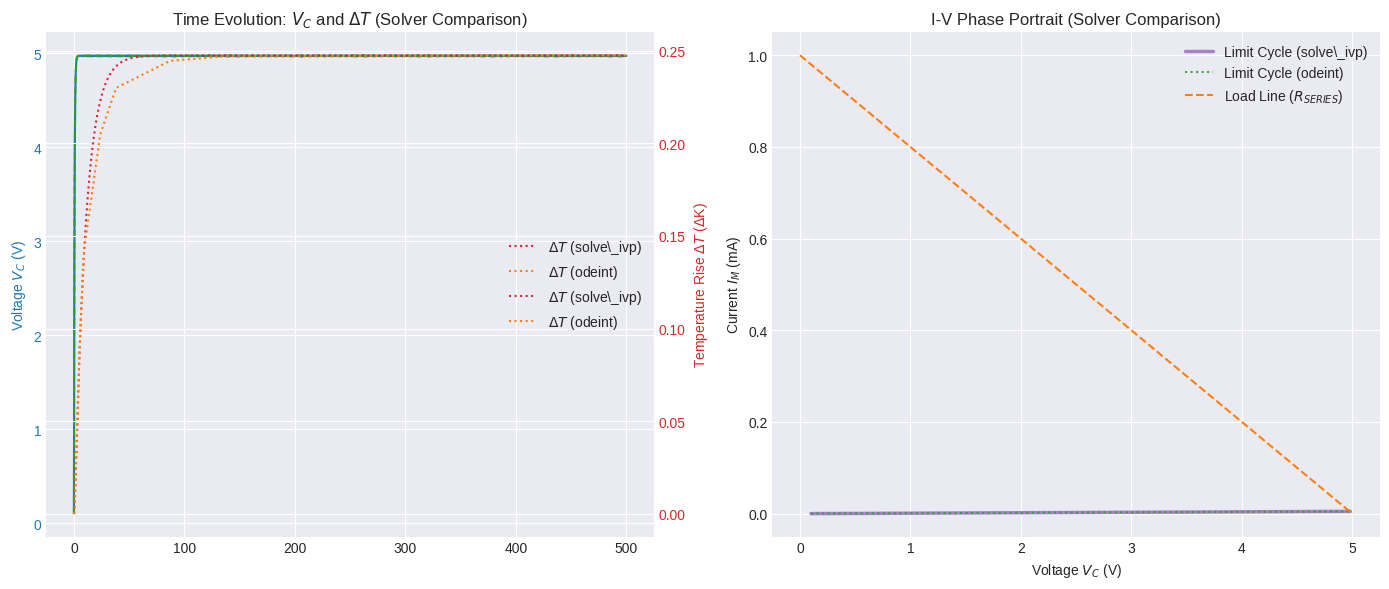


--- Simulation Summary ---
Solver Comparison (Min/Max V_C):
solve_ivp: 0.100 V to 4.981 V
odeint:    0.100 V to 4.975 V

Solver Comparison (Min/Max T):
solve_ivp: 300.0 K to 300.2 K
odeint:    300.0 K to 300.2 K

NDR device must have an S-type characteristic for these parameters to oscillate.


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp, odeint # Added odeint
import matplotlib.pyplot as plt

# --- 1. Circuit and Model Parameters ---

# Circuit parameters (External components)
V_BIAS = 5.0    # DC Supply Voltage (Volts)
R_SERIES = 5e3  # Series Load Resistor (Ohms). Must be large enough to enable NDR operation.
C_CAP = 100e-9  # External Capacitor (Farads). Provides the slow voltage dynamics.

# Thermal NDR Model Parameters (Device parameters)
T_AMB = 300.0   # Ambient Temperature (Kelvin)
C_TH = 1e-6     # Thermal Capacitance (J/K)
G_TH = 1e-4     # Thermal Conductance to ambient (W/K) (1/R_th)

# Electrical Conductance Parameters
# This model uses an Arrhenius-like temperature dependence for conductance,
# which is common for oxide-based threshold switches.
G_0 = 1e-6      # Low-temp (leakage) conductance (Siemens)
G_1 = 0.5e-3    # Factor for high-temp conductance (Siemens)
E_A = 0.4       # Activation Energy (eV) - determines sensitivity to temp
K_B = 8.617e-5  # Boltzmann Constant (eV/K)

# --- 2. Defining the System of ODEs (The Derivatives) ---

def electro_thermal_ndr_ode(t, Y):
    """
    Defines the system of two coupled ordinary differential equations (ODEs)
    using the standard (t, Y) signature required by solve_ivp.

    The state vector Y = [V_C, T].
    """
    V_C, T = Y

    # --- Step 1: Calculate the NDR device's dynamic conductance G(T) ---
    try:
        G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
    except OverflowError:
        G_M = G_0

    # --- Step 2: Calculate Current and Power ---
    I_M = G_M * V_C  # Current through the NDR device
    P_M = I_M * V_C  # Power dissipated by Joule heating

    # --- Step 3: Calculate the Derivatives ---

    # 1. dV_C/dt (Electrical Circuit Equation - KCL)
    I_R = (V_BIAS - V_C) / R_SERIES
    dV_C_dt = (I_R - I_M) / C_CAP

    # 2. dT/dt (Thermal Equation - Energy Balance)
    P_diss = G_TH * (T - T_AMB)
    dT_dt = (P_M - P_diss) / C_TH

    return np.array([dV_C_dt, dT_dt])

# Function required by odeint (takes Y, then t)
def electro_thermal_ndr_ode_odeint(Y, t):
    """Wrapper function for odeint, swaps (Y, t) arguments to call the main ODE."""
    return electro_thermal_ndr_ode(t, Y)

# Helper function to calculate current from simulated voltage and temperature
def calculate_currents(V_C_array, T_array):
    I_M_array = np.zeros_like(V_C_array)
    for i in range(len(V_C_array)):
        T = T_array[i]
        # Calculate conductance G(T) for each time step
        G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
        I_M_array[i] = G_M * V_C_array[i]
    return I_M_array

# --- 3. Simulation Setup and Execution ---

# Initial conditions (V_C and T)
Y0 = np.array([0.1, T_AMB])

# Time span for the simulation
T_SPAN = [0, 0.5] # 0 to 0.5 seconds
T_POINTS = np.linspace(T_SPAN[0], T_SPAN[1], 5000)

print(f"Starting simulation for {T_SPAN[1]} seconds...")

# --- Solve with solve_ivp (RK45) ---
solution_ivp = solve_ivp(
    electro_thermal_ndr_ode,
    T_SPAN,
    Y0,
    t_eval=T_POINTS,
    method='RK45', # Runge-Kutta method for accuracy
    atol=1e-6,
    rtol=1e-3
)

V_C_ivp = solution_ivp.y[0]
T_ivp = solution_ivp.y[1]
t_sim = solution_ivp.t
I_M_ivp = calculate_currents(V_C_ivp, T_ivp)
print("solve_ivp simulation finished.")

# --- Solve with odeint ---
print("\nStarting simulation using odeint...")
Y_odeint = odeint(
    electro_thermal_ndr_ode_odeint, # Use the odeint-compatible wrapper function
    Y0,
    T_POINTS,
    atol=1e-6,
    rtol=1e-3
)

V_C_odeint = Y_odeint[:, 0]
T_odeint = Y_odeint[:, 1]
I_M_odeint = calculate_currents(V_C_odeint, T_odeint)
print("odeint simulation finished. Plotting results.")


# --- 4. Plotting Results ---

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 6))

# --- Plot 1: Voltage and Temperature vs. Time (Comparison) ---
plt.subplot(1, 2, 1)

# Plot solve_ivp voltage (Blue solid)
plt.plot(t_sim * 1000, V_C_ivp, label=r'$V_C$ (solve\_ivp)', color='tab:blue')
# Plot odeint voltage (Green dashed)
plt.plot(t_sim * 1000, V_C_odeint, label=r'$V_C$ (odeint)', color='tab:green', linestyle='--')
plt.ylabel('Voltage $V_C$ (V)', color='tab:blue')
plt.tick_params(axis='y', labelcolor='tab:blue')

# Create a second axis for temperature
ax2 = plt.gca().twinx()
# Plot solve_ivp temperature (Red solid)
ax2.plot(t_sim * 1000, T_ivp - T_AMB, label=r'$\Delta T$ (solve\_ivp)', color='tab:red', linestyle=':')
# Plot odeint temperature (Orange dashed)
ax2.plot(t_sim * 1000, T_odeint - T_AMB, label=r'$\Delta T$ (odeint)', color='tab:orange', linestyle=':')
ax2.set_ylabel(r'Temperature Rise $\Delta T$ ($\Delta$K)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Time Evolution: $V_C$ and $\Delta T$ (Solver Comparison)')
plt.xlabel('Time (ms)')
# Merge legends from both axes
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')


# --- Plot 2: NDR I-V Characteristic (Phase Portrait Comparison) ---
plt.subplot(1, 2, 2)
# Calculate the load line
V_C_load = np.linspace(0, V_BIAS, 100)
I_R_load = (V_BIAS - V_C_load) / R_SERIES

# Plot solve_ivp Limit Cycle
plt.plot(V_C_ivp, I_M_ivp * 1000, label='Limit Cycle (solve\_ivp)', color='tab:purple', linewidth=2.5, alpha=0.8)
# Plot odeint Limit Cycle
plt.plot(V_C_odeint, I_M_odeint * 1000, label='Limit Cycle (odeint)', color='tab:green', linewidth=1.5, linestyle=':', alpha=0.9)

plt.plot(V_C_load, I_R_load * 1000, label=r'Load Line ($R_{SERIES}$)', color='tab:orange', linestyle='--')

plt.title('I-V Phase Portrait (Solver Comparison)')
plt.xlabel('Voltage $V_C$ (V)')
plt.ylabel('Current $I_M$ (mA)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Print Final Oscillation Info ---
print("\n--- Simulation Summary ---")
print("Solver Comparison (Min/Max V_C):")
print(f"solve_ivp: {np.min(V_C_ivp):.3f} V to {np.max(V_C_ivp):.3f} V")
print(f"odeint:    {np.min(V_C_odeint):.3f} V to {np.max(V_C_odeint):.3f} V")

print("\nSolver Comparison (Min/Max T):")
print(f"solve_ivp: {np.min(T_ivp):.1f} K to {np.max(T_ivp):.1f} K")
print(f"odeint:    {np.min(T_odeint):.1f} K to {np.max(T_odeint):.1f} K")

print("\nNDR device must have an S-type characteristic for these parameters to oscillate.")

### Trial 1

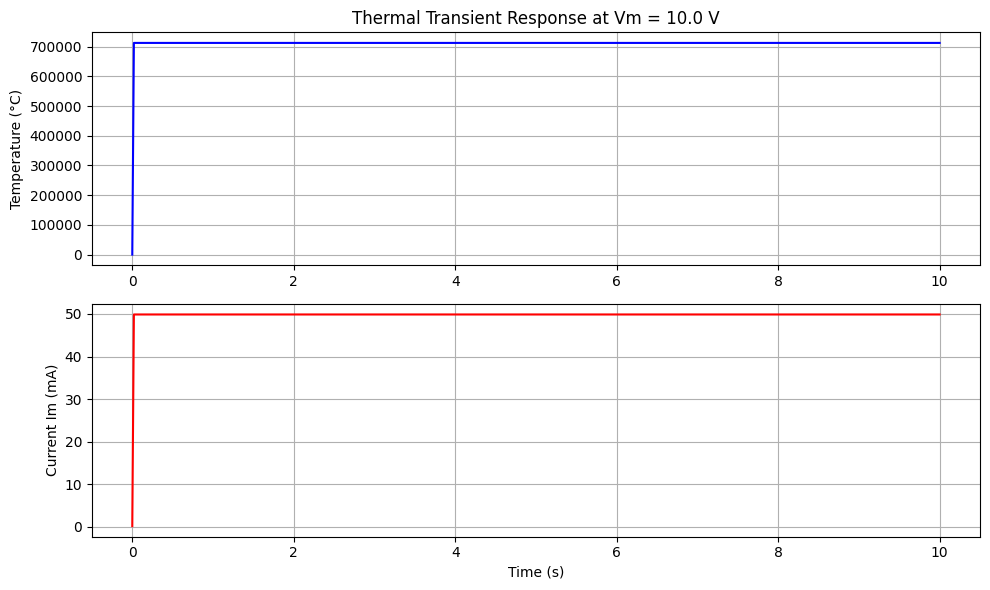

Final steady-state temperature: 712884.40 K (712611.25 °C)
Final steady-state current: 49.88 mA


In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
# Use placeholder values (you should replace these with actual values)
# C_th = 0.01      # Thermal capacitance (J/K)
# g0 = 1.0e-3      # Conductance prefactor (S)
# g1 = 3000.0      # Activation energy parameter (K)
# g_th = 0.005     # Thermal conductance to ambient (W/K)
# T_amb = 293.15   # Ambient temperature (K, e.g., 20°C)
V_m_dc = 10.0    # Fixed DC Voltage input (V)
g0=5e-3;
g1=1700;
C_th=1e-14;
g_th=0.7e-6;
T_amb=300;
# Rs= 200;

# Vb=1.5; Rb=2e3;

# --- 2. Define the System of Equations ---
def thermal_model_ode(T, t, V_m, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt (Equation 2 rearranged).

    Parameters:
    T: Current temperature (K). This is the state variable.
    t: Time (s).
    V_m, C_th, g0, g1, g_th, T_amb: Model constants.
    """

    # Equation 3: Conductance G(T)
    # The temperature T must be positive, which is true for Kelvin.
    G_T = g0 * np.exp(-g1 / T)

    # Equation 1 & 2: Power balance (P_in - P_out)
    # P_in = V_m * I_m = V_m * (V_m * G_T) = V_m**2 * G_T
    P_in = V_m**2 * G_T

    # P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 3. Simulation Setup ---

# Initial Condition: Assume the device starts at ambient temperature
T_initial = T_amb

# Time vector for the simulation (e.g., 0 to 10 seconds)
t = np.linspace(0, 10, 500)

# --- 4. Solve the ODE ---
# 'args' passes the model constants to the ODE function
T_transient = odeint(
    thermal_model_ode,
    T_initial,
    t,
    args=(V_m_dc, C_th, g0, g1, g_th, T_amb)
)

# Reshape the output for easier use (odeint returns an array of arrays)
T_transient = T_transient.flatten()

# --- 5. Calculate Current (Im) from Temperature ---
# We use the final temperature array to calculate the corresponding current array
def calculate_current(T, V_m, g0, g1):
    """Calculates Im = Vm * G(T)"""
    G_T = g0 * np.exp(-g1 / T)
    I_m = V_m * G_T
    return I_m

I_m_transient = calculate_current(T_transient, V_m_dc, g0, g1)

# --- 6. Plot the DC Transient Curve ---
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, T_transient - 273.15, 'b-') # Plot in Celsius for readability
plt.title(f'Thermal Transient Response at Vm = {V_m_dc} V')
plt.ylabel('Temperature (°C)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, I_m_transient * 1000, 'r-') # Plot in mA for readability
plt.xlabel('Time (s)')
plt.ylabel('Current Im (mA)')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final steady-state temperature: {T_transient[-1]:.2f} K ({T_transient[-1] - 273.15:.2f} °C)")
print(f"Final steady-state current: {I_m_transient[-1]*1000:.2f} mA")

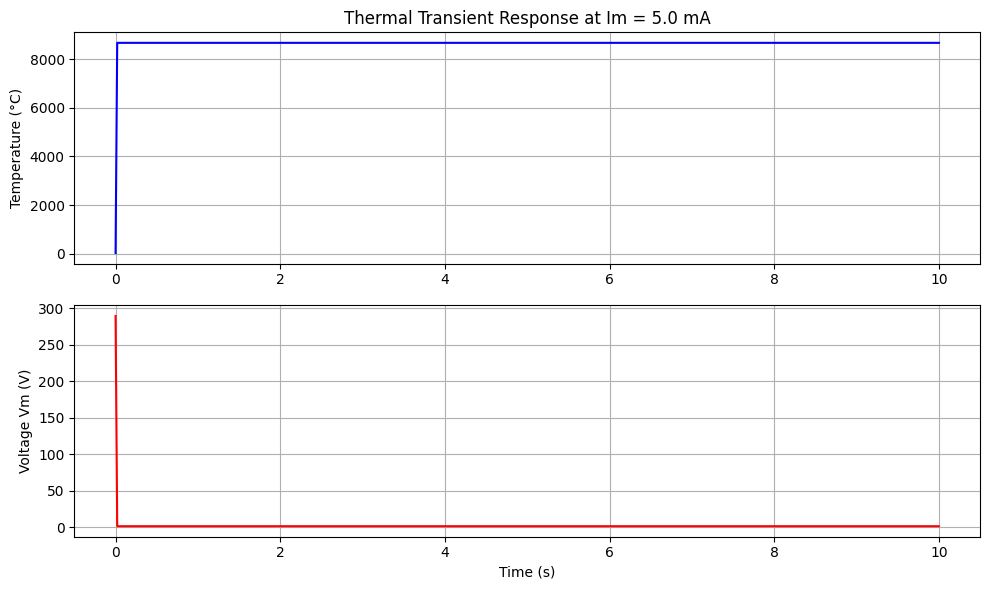

Fixed DC Current: 5.00 mA
Final steady-state temperature: 8939.03 K (8665.88 °C)
Final steady-state voltage: 1.21 V


In [9]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
# Using the same placeholder values as before
# C_th = 0.01      # Thermal capacitance (J/K)
# g0 = 1.0e-3      # Conductance prefactor (S)
# g1 = 3000.0      # Activation energy parameter (K)
# g_th = 0.005     # Thermal conductance to ambient (W/K)
# T_amb = 293.15   # Ambient temperature (K, e.g., 20°C)
g0=5e-3;
g1=1700;
C_th=1e-14;
g_th=0.7e-6;
T_amb=300;
I_m_dc = 0.005   # Fixed DC Current input (A) - e.g., 5 mA

# --- 2. Define the System of Equations (dT/dt) ---
def thermal_model_ode_constant_current(T, t, I_m, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt for the constant current case.

    Parameters:
    T: Current temperature (K).
    t: Time (s).
    I_m, C_th, g0, g1, g_th, T_amb: Model constants.
    """

    # Calculate Power Input P_in = Vm * Im.
    # Since Vm = Im / G(T) and G(T) = g0 * exp(-g1 / T),
    # P_in = Im * (Im / G(T)) = Im**2 / G(T) = (Im**2 / g0) * exp(g1 / T)

    # P_in Calculation
    P_in = (I_m**2 / g0) * np.exp(g1 / T)

    # Power Output P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 3. Simulation Setup ---

# Initial Condition: Assume the device starts at ambient temperature
T_initial = T_amb

# Time vector for the simulation (e.g., 0 to 10 seconds)
t = np.linspace(0, 10, 500)

# --- 4. Solve the ODE ---
T_transient = odeint(
    thermal_model_ode_constant_current,
    T_initial,
    t,
    args=(I_m_dc, C_th, g0, g1, g_th, T_amb)
)

# Reshape the output for easier use
T_transient = T_transient.flatten()

# --- 5. Calculate Voltage (Vm) from Temperature ---
# We use the final temperature array to calculate the corresponding voltage array
def calculate_voltage(T, I_m, g0, g1):
    """Calculates Vm = Im / G(T)"""
    # G(T) = g0 * exp(-g1 / T)
    G_T = g0 * np.exp(-g1 / T)
    V_m = I_m / G_T
    return V_m

V_m_transient = calculate_voltage(T_transient, I_m_dc, g0, g1)

# --- 6. Plot the DC Transient Curve ---
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, T_transient - 273.15, 'b-') # Plot in Celsius
plt.title(f'Thermal Transient Response at Im = {I_m_dc * 1000} mA')
plt.ylabel('Temperature (°C)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, V_m_transient, 'r-')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Vm (V)')
plt.grid(True)

plt.tight_layout()
plt.savefig("constant_current_transient.png")
plt.show()

print(f"Fixed DC Current: {I_m_dc * 1000:.2f} mA")
print(f"Final steady-state temperature: {T_transient[-1]:.2f} K ({T_transient[-1] - 273.15:.2f} °C)")
print(f"Final steady-state voltage: {V_m_transient[-1]:.2f} V")

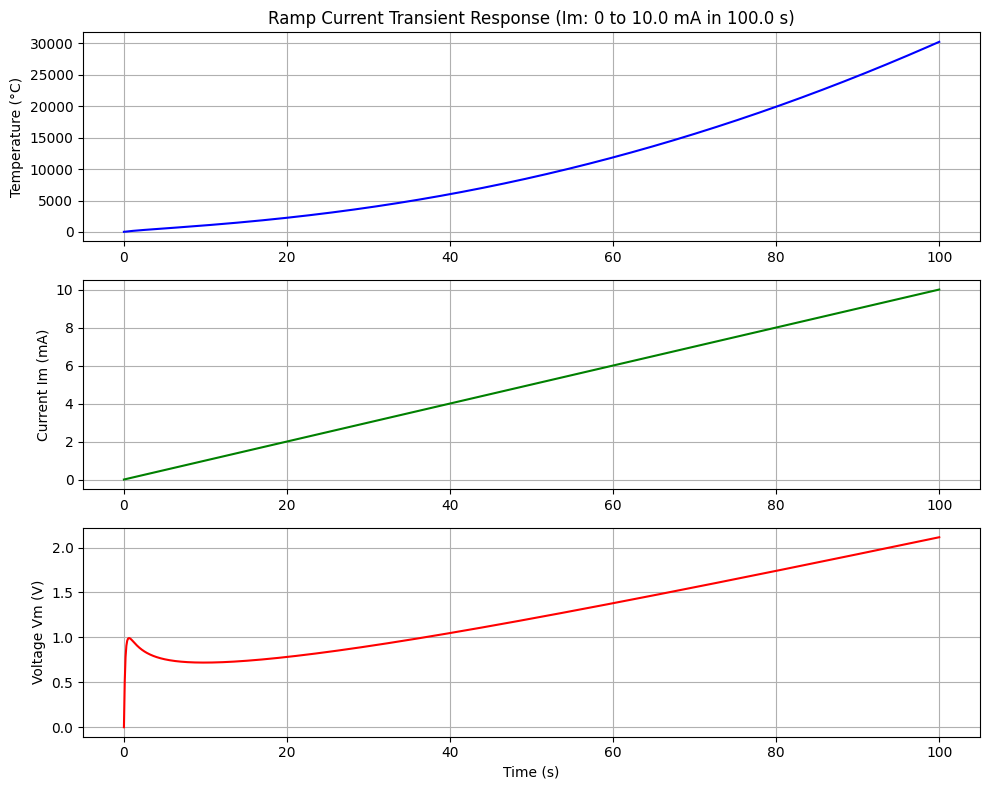

Ramp Slope: 0.1000 mA/s
Final Maximum Current: 10.00 mA
Final Steady-state Temperature: 30508.67 K (30235.52 °C)
Final Voltage: 2.11 V


In [10]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
# C_th = 0.01      # Thermal capacitance (J/K)
# g0 = 1.0e-3      # Conductance prefactor (S)
# g1 = 3000.0      # Activation energy parameter (K)
# g_th = 0.005     # Thermal conductance to ambient (W/K)
# T_amb = 293.15   # Ambient temperature (K, e.g., 20°C)
g0=5e-3;
g1=1700;
C_th=1e-14;
g_th=0.7e-6;
T_amb=300;


# --- 2. Define Ramp Parameters ---
T_max_simulation = 100.0 # Total simulation time (s) for low frequency
I_max_ramp = 0.01      # Maximum current reached (A)
ramp_slope = I_max_ramp / T_max_simulation # Ramp slope (A/s)

# --- 3. Ramp Current Function I_m(t) ---
def I_m_ramp(t, ramp_slope, I_max):
    """Calculates the instantaneous ramp current, limited by I_max."""
    # Current increases linearly with time, but is clipped at I_max
    return np.clip(ramp_slope * t, 0, I_max)

# --- 4. Define the System of Equations (dT/dt) ---
def thermal_model_ode_ramp_current(T, t, ramp_slope, I_max, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt for the time-dependent ramp current case.

    The instantaneous current I_m(t) is calculated inside this function.
    """

    # Calculate I_m(t) at the current time t
    I_m = I_m_ramp(t, ramp_slope, I_max)

    # Calculate Power Input P_in = I_m^2 / G(T)
    # G(T) = g0 * exp(-g1 / T)

    # Calculate Power Input P_in = Vm * Im = Im**2 / G(T)
    # We can skip the `if I_m == 0` check if we use a small value for g0 * exp(-g1 / T) to avoid Inf,
    # but since I_m starts at zero, the condition is clearer.
    if I_m == 0:
        P_in = 0.0
    else:
        # P_in = (I_m**2 / g0) * exp(g1 / T)
        P_in = (I_m**2 / g0) * np.exp(g1 / T)

    # Power Output P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 5. Simulation Setup and Solution ---

T_initial = T_amb
t = np.linspace(0, T_max_simulation, 1000) # Time vector

# Solve the ODE
T_transient = odeint(
    thermal_model_ode_ramp_current,
    T_initial,
    t,
    args=(ramp_slope, I_max_ramp, C_th, g0, g1, g_th, T_amb)
)
T_transient = T_transient.flatten()

# --- 6. Calculate I_m(t) and V_m(t) ---

# I_m(t) at all time steps
I_m_transient = I_m_ramp(t, ramp_slope, I_max_ramp)

# V_m(t) calculation: Vm = Im / G(T) = (Im / g0) * exp(g1 / T)
def calculate_voltage(T, I_m, g0, g1):
    """Calculates Vm = Im / G(T)"""
    # G(T) = g0 * exp(-g1 / T)
    G_T = g0 * np.exp(-g1 / T)
    V_m = I_m / G_T
    return V_m

V_m_transient = calculate_voltage(T_transient, I_m_transient, g0, g1)

# --- 7. Plot the DC Transient Curve ---
plt.figure(figsize=(10, 8))

# Subplot 1: Temperature
plt.subplot(3, 1, 1)
plt.plot(t, T_transient - 273.15, 'b-')
plt.title(f'Ramp Current Transient Response (Im: 0 to {I_max_ramp * 1000} mA in {T_max_simulation} s)')
plt.ylabel('Temperature (°C)')
plt.grid(True)

# Subplot 2: Current (Input)
plt.subplot(3, 1, 2)
plt.plot(t, I_m_transient * 1000, 'g-')
plt.ylabel('Current Im (mA)')
plt.grid(True)

# Subplot 3: Voltage (Output)
plt.subplot(3, 1, 3)
plt.plot(t, V_m_transient, 'r-')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Vm (V)')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Ramp Slope: {ramp_slope*1000:.4f} mA/s")
print(f"Final Maximum Current: {I_m_transient[-1]*1000:.2f} mA")
print(f"Final Steady-state Temperature: {T_transient[-1]:.2f} K ({T_transient[-1] - 273.15:.2f} °C)")
print(f"Final Voltage: {V_m_transient[-1]:.2f} V")

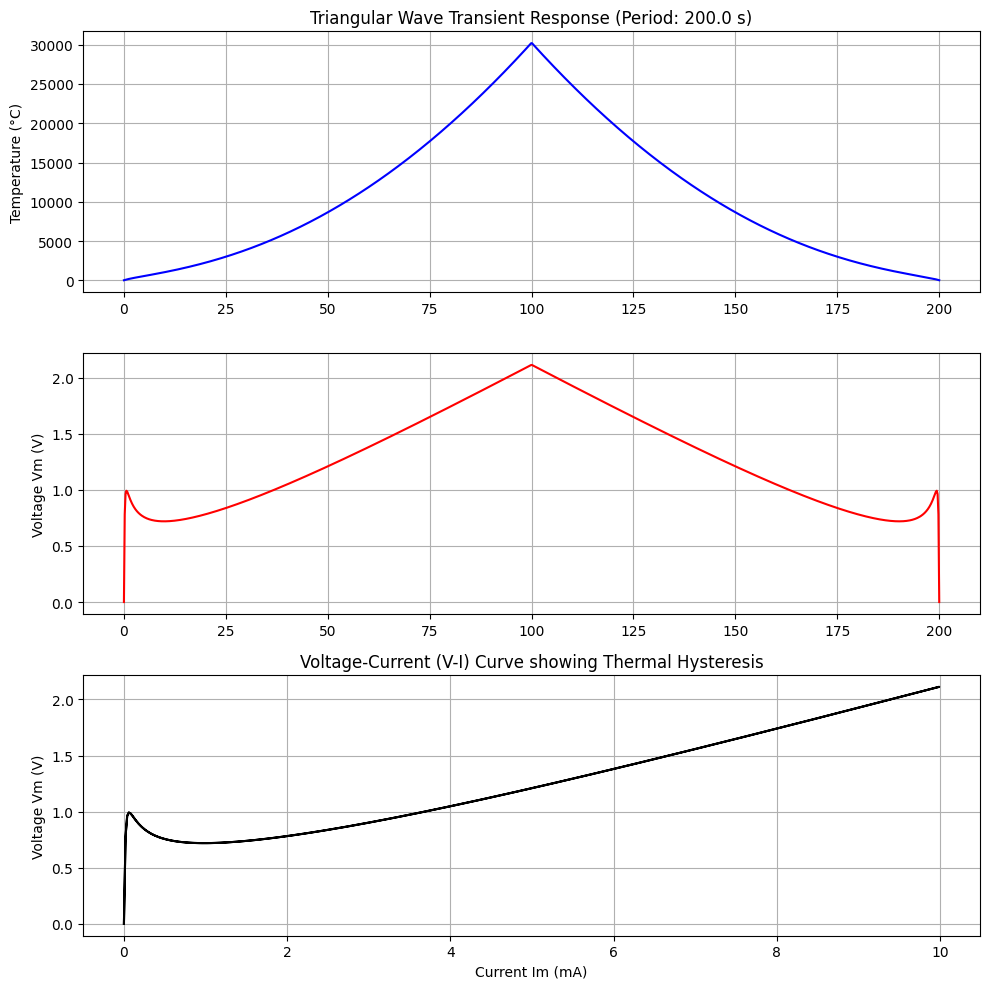

Cycle Period: 200.0 s
Peak Current: 10.00 mA
Max Temperature Reached: 30451.39 K (30178.24 °C)


In [12]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
# C_th = 0.01      # Thermal capacitance (J/K)
# g0 = 1.0e-3      # Conductance prefactor (S)
# g1 = 3000.0      # Activation energy parameter (K)
# g_th = 0.005     # Thermal conductance to ambient (W/K)
# T_amb = 293.15   # Ambient temperature (K, e.g., 20°C)
g0=5e-3;
g1=1700;
C_th=1e-14;
g_th=0.7e-6;
T_amb=300;

# --- 2. Define Triangular Wave Parameters ---
I_max_peak = 0.01      # Peak current (A)
T_cycle = 200.0        # Total time for one cycle (s)
t_ramp = T_cycle / 2.0 # Time for upward ramp (100.0 s)
ramp_slope = I_max_peak / t_ramp # Slope magnitude (A/s)

T_max_simulation = T_cycle # Simulate for one full cycle

# --- 3. Triangular Current Function I_m(t) ---
def I_m_triangular(t, ramp_slope, I_max, t_ramp, T_cycle):
    """Calculates the instantaneous triangular current wave."""

    # Use modulo to handle continuous cycles (though we only simulate one)
    t_mod = np.fmod(t, T_cycle)

    if t_mod <= t_ramp:
        # Upward ramp phase: I_m = slope * t
        I_m = ramp_slope * t_mod
    else:
        # Downward ramp phase: I_m starts from I_max and goes down to 0
        # Time into the downward ramp: (t_mod - t_ramp)
        # Current = I_max - (slope * time_into_downward_ramp)
        I_m = I_max - ramp_slope * (t_mod - t_ramp)

    # Ensure current is non-negative due to float precision
    return max(0.0, I_m)

# --- 4. Define the System of Equations (dT/dt) ---
def thermal_model_ode_triangular_current(T, t, ramp_slope, I_max, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt for the time-dependent triangular current case.
    """

    # Calculate I_m(t) at the current time t
    I_m = I_m_triangular(t, ramp_slope, I_max, t_ramp, T_cycle)

    # Calculate Power Input P_in = I_m^2 / G(T)
    if I_m == 0:
        P_in = 0.0
    else:
        # P_in = (I_m**2 / g0) * exp(g1 / T)
        P_in = (I_m**2 / g0) * np.exp(g1 / T)

    # Power Output P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 5. Simulation Setup and Solution ---

T_initial = T_amb
t = np.linspace(0, T_max_simulation, 1000) # Time vector for the full cycle

# Solve the ODE
T_transient = odeint(
    thermal_model_ode_triangular_current,
    T_initial,
    t,
    args=(ramp_slope, I_max_peak, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb)
)
T_transient = T_transient.flatten()

# --- 6. Calculate I_m(t) and V_m(t) ---

# I_m(t) at all time steps
I_m_transient = np.array([I_m_triangular(ti, ramp_slope, I_max_peak, t_ramp, T_cycle) for ti in t])

# V_m(t) calculation: Vm = Im / G(T) = (Im / g0) * exp(g1 / T)
def calculate_voltage(T, I_m, g0, g1):
    """Calculates Vm = Im / G(T)"""
    G_T = g0 * np.exp(-g1 / T)
    # Ensure V_m is 0 when I_m is 0
    V_m = np.where(I_m > 0, I_m / G_T, 0.0)
    return V_m

V_m_transient = calculate_voltage(T_transient, I_m_transient, g0, g1)

# --- 7. Plot the Transients (T vs t, Vm vs t) and the Hysteresis (Vm vs Im) ---
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Subplot 1: Temperature vs Time
axes[0].plot(t, T_transient - 273.15, 'b-')
axes[0].set_title(f'Triangular Wave Transient Response (Period: {T_cycle} s)')
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(True)

# Subplot 2: Voltage vs Time
axes[1].plot(t, V_m_transient, 'r-')
axes[1].set_ylabel('Voltage Vm (V)')
axes[1].grid(True)

# Subplot 3: V-I Curve (Hysteresis Loop)
axes[2].plot(I_m_transient * 1000, V_m_transient, 'k-')
axes[2].set_xlabel('Current Im (mA)')
axes[2].set_ylabel('Voltage Vm (V)')
axes[2].set_title('Voltage-Current (V-I) Curve showing Thermal Hysteresis')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"Cycle Period: {T_cycle:.1f} s")
print(f"Peak Current: {I_max_peak*1000:.2f} mA")
print(f"Max Temperature Reached: {T_transient.max():.2f} K ({T_transient.max() - 273.15:.2f} °C)")

/tmp/ipython-input-2828640964.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


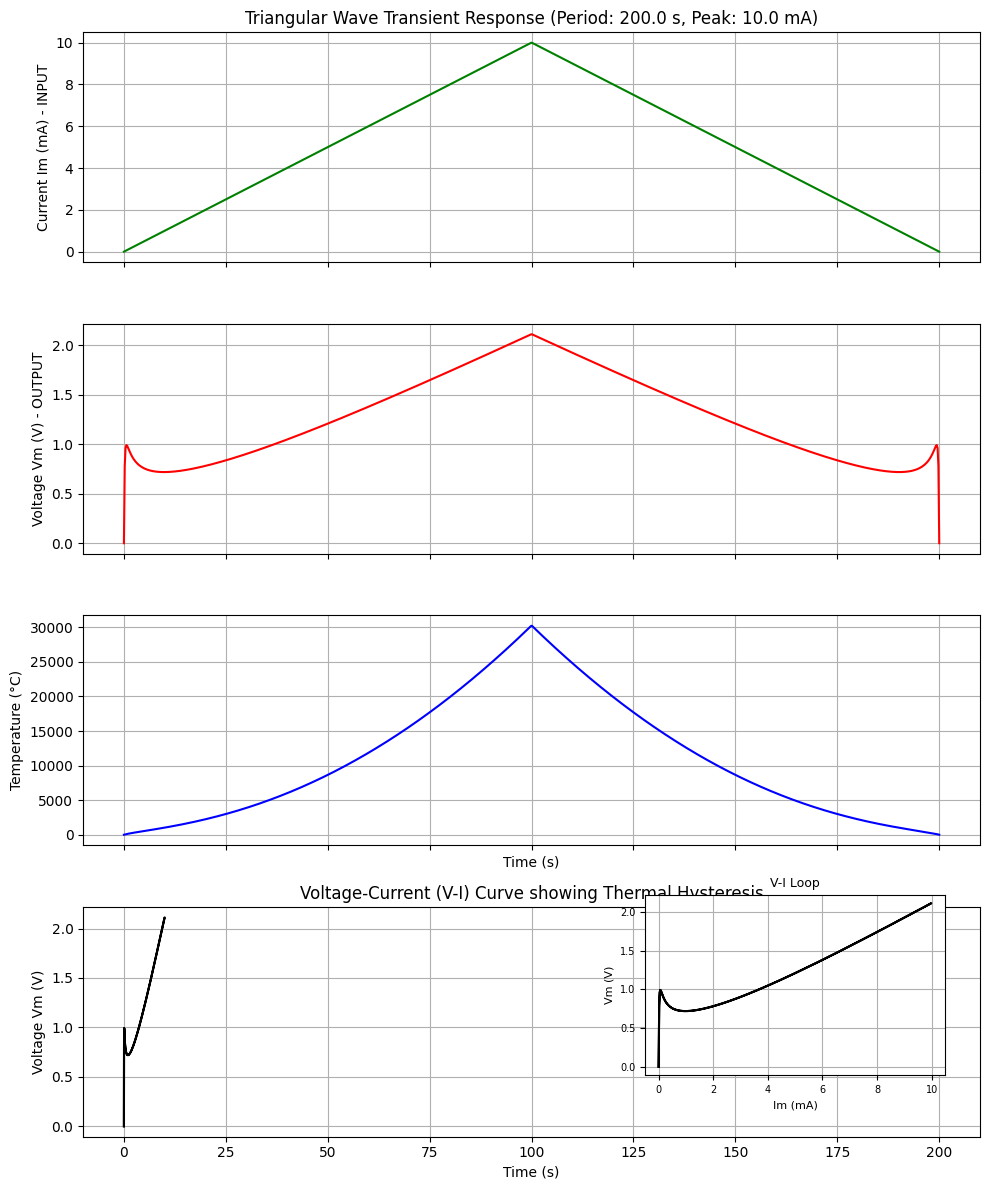

Thermal Time Constant (C_th / g_th): 1.43e-08 seconds
Cycle Period: 200.0 s
-----------------------------------
Peak Current: 10.00 mA
Max Temperature Reached: 30451.39 K (30178.24 °C)
Voltage at Peak Current: 2.11 V


In [16]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
g0 = 5e-3        # Conductance prefactor (S)
g1 = 1700.0      # Activation energy parameter (K)
C_th = 1e-14     # Thermal capacitance (J/K)
g_th = 0.7e-6    # Thermal conductance to ambient (W/K)
T_amb = 300.0    # Ambient temperature (K)

# --- 2. Define Triangular Wave Parameters ---
I_max_peak = 0.01      # Peak current (A)
T_cycle = 200.0        # Total time for one cycle (s)
t_ramp = T_cycle / 2.0 # Time for upward ramp (100.0 s)
ramp_slope = I_max_peak / t_ramp # Slope magnitude (A/s)

T_max_simulation = T_cycle # Simulate for one full cycle

# --- 3. Triangular Current Function I_m(t) ---
def I_m_triangular(t, ramp_slope, I_max, t_ramp, T_cycle):
    """Calculates the instantaneous triangular current wave."""

    t_mod = np.fmod(t, T_cycle)

    if t_mod <= t_ramp:
        # Upward ramp phase: I_m = slope * t
        I_m = ramp_slope * t_mod
    else:
        # Downward ramp phase
        I_m = I_max - ramp_slope * (t_mod - t_ramp)

    return max(0.0, I_m)

# --- 4. Define the System of Equations (dT/dt) ---
def thermal_model_ode_triangular_current(T, t, ramp_slope, I_max, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt for the time-dependent triangular current case.
    """

    I_m = I_m_triangular(t, ramp_slope, I_max, t_ramp, T_cycle)

    # Calculate Power Input P_in = I_m^2 / G(T)
    if I_m == 0:
        P_in = 0.0
    else:
        # P_in = (I_m**2 / g0) * exp(g1 / T)
        # Note: Given the parameters, the Max Temperature Reached is very high (~30000 K)
        # We handle this large number, but it suggests the model parameters might be non-physical for this current level.
        P_in = (I_m**2 / g0) * np.exp(g1 / T)

    # Power Output P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 5. Simulation Setup and Solution ---

T_initial = T_amb
t = np.linspace(0, T_max_simulation, 1000) # Time vector for the full cycle

# Solve the ODE
T_transient = odeint(
    thermal_model_ode_triangular_current,
    T_initial,
    t,
    args=(ramp_slope, I_max_peak, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb)
)
T_transient = T_transient.flatten()

# --- 6. Calculate I_m(t) and V_m(t) ---

I_m_transient = np.array([I_m_triangular(ti, ramp_slope, I_max_peak, t_ramp, T_cycle) for ti in t])

def calculate_voltage(T, I_m, g0, g1):
    """Calculates Vm = Im / G(T)"""
    G_T = g0 * np.exp(-g1 / T)
    V_m = np.where(I_m > 0, I_m / G_T, 0.0)
    return V_m

V_m_transient = calculate_voltage(T_transient, I_m_transient, g0, g1)

# --- 7. Plotting the Results ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Subplot 1: Current vs Time (Input Signal) 🟢
axes[0].plot(t, I_m_transient * 1000, 'g-')
axes[0].set_title(f'Triangular Wave Transient Response (Period: {T_cycle} s, Peak: {I_max_peak * 1000} mA)')
axes[0].set_ylabel('Current Im (mA) - INPUT')
axes[0].grid(True)

# Subplot 2: Voltage vs Time (Output Signal) 🔴
axes[1].plot(t, V_m_transient, 'r-')
axes[1].set_ylabel('Voltage Vm (V) - OUTPUT')
axes[1].grid(True)

# Subplot 3: Temperature vs Time 🔵
axes[2].plot(t, T_transient - 273.15, 'b-')
axes[2].set_ylabel('Temperature (°C)')
axes[2].grid(True)

# Subplot 4: V-I Curve (Hysteresis Loop) ⚫
axes[3].plot(I_m_transient * 1000, V_m_transient, 'k-')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Voltage Vm (V)')
axes[3].set_title('Voltage-Current (V-I) Curve showing Thermal Hysteresis')
axes[3].grid(True)

# Add an I-V plot in the bottom right corner for better visualization of the loop
ax_iv = fig.add_axes([0.65, 0.1, 0.3, 0.15]) # [left, bottom, width, height]
ax_iv.plot(I_m_transient * 1000, V_m_transient, 'k-')
ax_iv.set_xlabel('Im (mA)', fontsize=8)
ax_iv.set_ylabel('Vm (V)', fontsize=8)
ax_iv.set_title('V-I Loop', fontsize=9)
ax_iv.tick_params(axis='both', which='major', labelsize=7)
ax_iv.grid(True)

axes[2].set_xlabel('Time (s)') # Set shared x-axis label on the third plot

plt.tight_layout()
plt.show()

# --- 8. Final Print Statements (Fixed Indexing) ---

# Thermal time constant is very small, leading to near-zero hysteresis.
print(f"Thermal Time Constant (C_th / g_th): {C_th / g_th:.2e} seconds")
print(f"Cycle Period: {T_cycle:.1f} s")
print("-" * 35)
print(f"Peak Current: {I_max_peak*1000:.2f} mA")
print(f"Max Temperature Reached: {T_transient.max():.2f} K ({T_transient.max() - 273.15:.2f} °C)")

# Fix for IndexError: Find the index where time 't' is closest to t_ramp (100.0 s)
peak_time_index = np.argmin(np.abs(t - t_ramp))
voltage_at_peak = V_m_transient[peak_time_index]
print(f"Voltage at Peak Current: {voltage_at_peak:.2f} V")

/tmp/ipython-input-3660242057.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


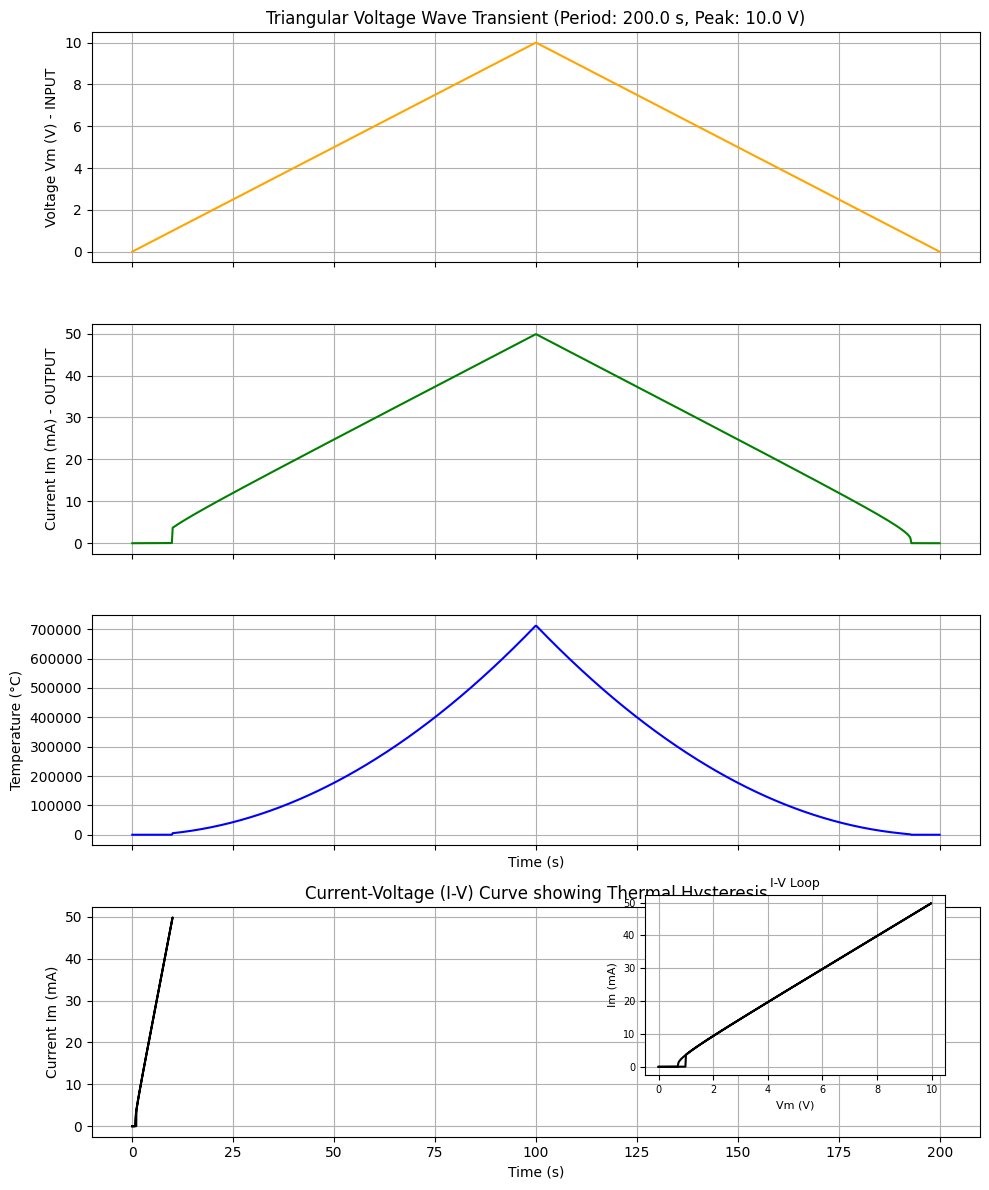

Thermal Time Constant (C_th / g_th): 1.43e-08 seconds
Cycle Period: 200.0 s
-----------------------------------
Peak Voltage: 10.00 V
Max Temperature Reached: 711455.11 K (711181.96 °C)
Current at Peak Voltage: 49.83 mA


In [17]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Define Constants and Fixed Parameters ---
g0 = 5e-3        # Conductance prefactor (S)
g1 = 1700.0      # Activation energy parameter (K)
C_th = 1e-14     # Thermal capacitance (J/K)
g_th = 0.7e-6    # Thermal conductance to ambient (W/K)
T_amb = 300.0    # Ambient temperature (K)

# --- 2. Define Triangular Wave Parameters ---
V_max_peak = 10.0      # Peak voltage (V)
T_cycle = 200.0        # Total time for one cycle (s)
t_ramp = T_cycle / 2.0 # Time for upward ramp (100.0 s)
ramp_slope = V_max_peak / t_ramp # Slope magnitude (V/s)

T_max_simulation = T_cycle # Simulate for one full cycle

# --- 3. Triangular Voltage Function V_m(t) ---
def V_m_triangular(t, ramp_slope, V_max, t_ramp, T_cycle):
    """Calculates the instantaneous triangular voltage wave."""

    t_mod = np.fmod(t, T_cycle)

    if t_mod <= t_ramp:
        # Upward ramp phase: V_m = slope * t
        V_m = ramp_slope * t_mod
    else:
        # Downward ramp phase
        V_m = V_max - ramp_slope * (t_mod - t_ramp)

    return max(0.0, V_m)

# --- 4. Define the System of Equations (dT/dt) ---
def thermal_model_ode_triangular_voltage(T, t, ramp_slope, V_max, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb):
    """
    Returns the derivative dT/dt for the time-dependent triangular voltage case.
    """

    # Calculate V_m(t) at the current time t
    V_m = V_m_triangular(t, ramp_slope, V_max, t_ramp, T_cycle)

    # Calculate Power Input P_in = V_m^2 * G(T)
    # G(T) = g0 * exp(-g1 / T)
    P_in = V_m**2 * g0 * np.exp(-g1 / T)

    # Power Output P_out = g_th * (T - T_amb)
    P_out = g_th * (T - T_amb)

    # dT/dt = (1/C_th) * (P_in - P_out)
    dTdt = (1.0 / C_th) * (P_in - P_out)

    return dTdt

# --- 5. Simulation Setup and Solution ---

T_initial = T_amb
t = np.linspace(0, T_max_simulation, 1000) # Time vector for the full cycle

# Solve the ODE
T_transient = odeint(
    thermal_model_ode_triangular_voltage,
    T_initial,
    t,
    args=(ramp_slope, V_max_peak, t_ramp, T_cycle, C_th, g0, g1, g_th, T_amb)
)
T_transient = T_transient.flatten()

# --- 6. Calculate V_m(t) and I_m(t) ---

# V_m(t) at all time steps
V_m_transient = np.array([V_m_triangular(ti, ramp_slope, V_max_peak, t_ramp, T_cycle) for ti in t])

# I_m(t) calculation: Im = Vm * G(T) = Vm * g0 * exp(-g1 / T)
def calculate_current(T, V_m, g0, g1):
    """Calculates Im = Vm * G(T)"""
    G_T = g0 * np.exp(-g1 / T)
    I_m = V_m * G_T
    return I_m

I_m_transient = calculate_current(T_transient, V_m_transient, g0, g1)

# --- 7. Plotting the Results ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Subplot 1: Voltage vs Time (Input Signal) 🟡
axes[0].plot(t, V_m_transient, color='orange')
axes[0].set_title(f'Triangular Voltage Wave Transient (Period: {T_cycle} s, Peak: {V_max_peak} V)')
axes[0].set_ylabel('Voltage Vm (V) - INPUT')
axes[0].grid(True)

# Subplot 2: Current vs Time (Output Signal) 🟢
axes[1].plot(t, I_m_transient * 1000, 'g-')
axes[1].set_ylabel('Current Im (mA) - OUTPUT')
axes[1].grid(True)

# Subplot 3: Temperature vs Time 🔵
axes[2].plot(t, T_transient - 273.15, 'b-')
axes[2].set_ylabel('Temperature (°C)')
axes[2].grid(True)

# Subplot 4: I-V Curve (Hysteresis Loop) ⚫
axes[3].plot(V_m_transient, I_m_transient * 1000, 'k-') # I vs V for standard I-V
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Current Im (mA)')
axes[3].set_title('Current-Voltage (I-V) Curve showing Thermal Hysteresis')
axes[3].grid(True)

# Add an I-V plot in the bottom right corner for better visualization of the loop
ax_iv = fig.add_axes([0.65, 0.1, 0.3, 0.15]) # [left, bottom, width, height]
ax_iv.plot(V_m_transient, I_m_transient * 1000, 'k-')
ax_iv.set_xlabel('Vm (V)', fontsize=8)
ax_iv.set_ylabel('Im (mA)', fontsize=8)
ax_iv.set_title('I-V Loop', fontsize=9)
ax_iv.tick_params(axis='both', which='major', labelsize=7)
ax_iv.grid(True)

axes[2].set_xlabel('Time (s)') # Set shared x-axis label on the third plot

plt.tight_layout()
plt.show()

# --- 8. Final Print Statements ---

# Fix for Index Error (Finding the peak time index)
peak_time_index = np.argmin(np.abs(t - t_ramp))
current_at_peak = I_m_transient[peak_time_index]

print(f"Thermal Time Constant (C_th / g_th): {C_th / g_th:.2e} seconds")
print(f"Cycle Period: {T_cycle:.1f} s")
print("-" * 35)
print(f"Peak Voltage: {V_max_peak:.2f} V")
print(f"Max Temperature Reached: {T_transient.max():.2f} K ({T_transient.max() - 273.15:.2f} °C)")
print(f"Current at Peak Voltage: {current_at_peak*1000:.2f} mA")